Выберите ряд из первого задания и постройте его модель ARIMA/GARCH. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
series = pd.read_csv("monthly-us-auto-registration-tho.csv", delimiter = ";")["Monthly U.S. auto registration (thousands) 1947 ? 1968"]
series = boxcox(series, 0)

ARIMA - естественное расширение модели ARMA. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель

$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

C:\Users\Aleksandr\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Aleksandr\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Aleksandr\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Aleksandr\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


aic: -274.32656 | order: (4, 1, 3)
Results of Dickey-Fuller Test:
Test Statistic                  -4.235692
p-value                          0.000573
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


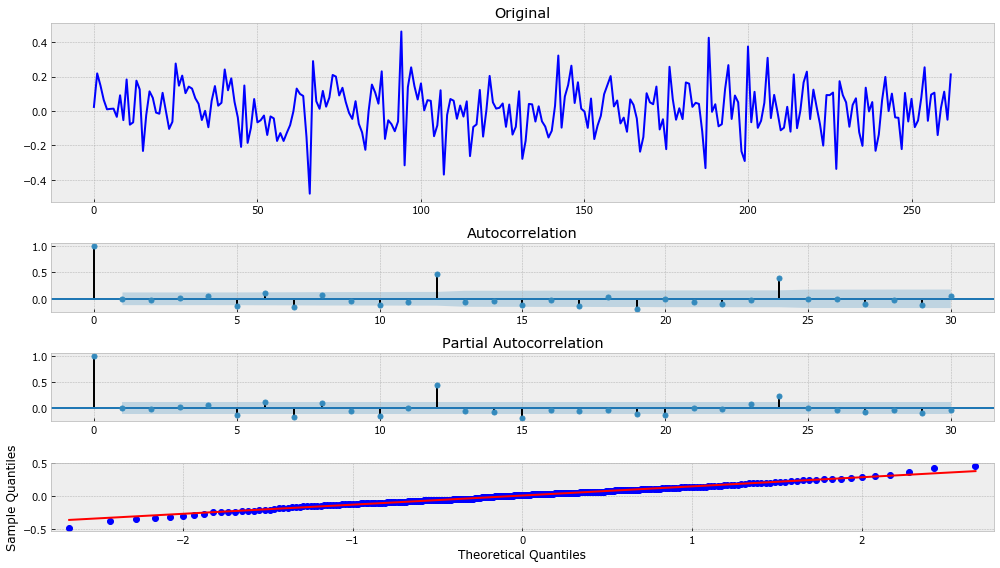

In [3]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

tsplot(best_mdl.resid, lags=30)

**Получили гиперпараметры p, d, q = 4, 1, 3. Остатки распределены случайным образом и образуют стационарный ряд.**

Попробуем спрогнозировать значения ряда

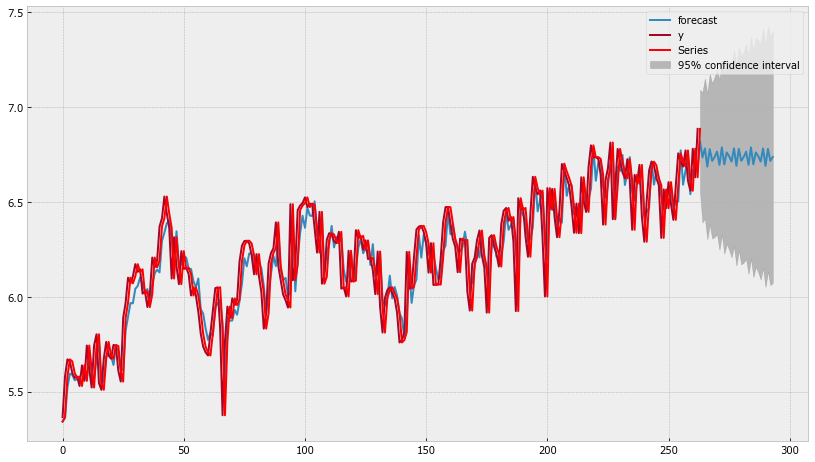

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+30, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

**Сгенерим фичи для построения модели линейной регрессии.**

In [5]:
df = pd.read_csv("monthly-us-auto-registration-tho.csv", delimiter = ";")
df.rename(columns={"Monthly U.S. auto registration (thousands) 1947 ? 1968":'Count'}, inplace=True)

In [6]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = prepareData(df, lag_start=1, lag_end=20, test_size=0.3)

In [8]:
X_train.columns

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19'],
      dtype='object')

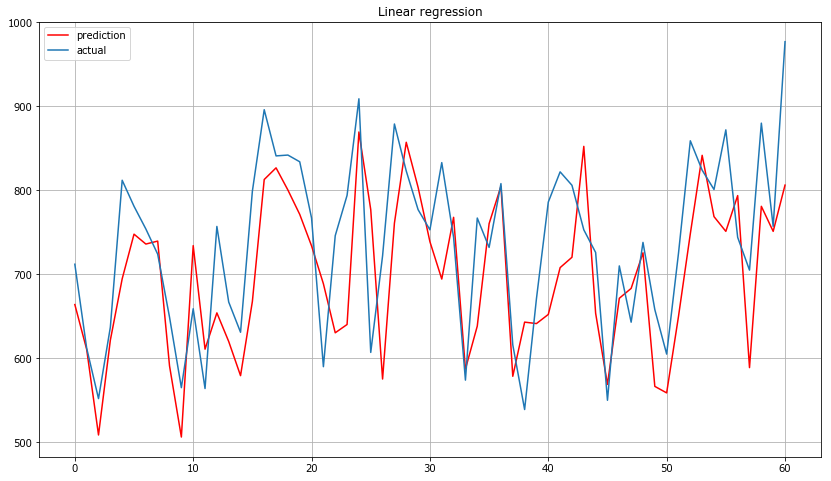

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

**Сгенерим новые признаки.**

In [10]:
for df in [X_train, X_test]:
    for i in range(1,19):

        df["sum_lags_{}".format(i)] = df.iloc[:,0:1+i].sum(axis=1)
        df["mean_lags_{}".format(i)] = df.iloc[:,0:1+i].mean(axis=1)
        df["std_lags_{}".format(i)] = df.iloc[:,0:1+i].std(axis=1)

In [11]:
X_train.columns

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'lag_16', 'lag_17', 'lag_18', 'lag_19', 'sum_lags_1', 'mean_lags_1',
       'std_lags_1', 'sum_lags_2', 'mean_lags_2', 'std_lags_2', 'sum_lags_3',
       'mean_lags_3', 'std_lags_3', 'sum_lags_4', 'mean_lags_4', 'std_lags_4',
       'sum_lags_5', 'mean_lags_5', 'std_lags_5', 'sum_lags_6', 'mean_lags_6',
       'std_lags_6', 'sum_lags_7', 'mean_lags_7', 'std_lags_7', 'sum_lags_8',
       'mean_lags_8', 'std_lags_8', 'sum_lags_9', 'mean_lags_9', 'std_lags_9',
       'sum_lags_10', 'mean_lags_10', 'std_lags_10', 'sum_lags_11',
       'mean_lags_11', 'std_lags_11', 'sum_lags_12', 'mean_lags_12',
       'std_lags_12', 'sum_lags_13', 'mean_lags_13', 'std_lags_13',
       'sum_lags_14', 'mean_lags_14', 'std_lags_14', 'sum_lags_15',
       'mean_lags_15', 'std_lags_15', 'sum_lags_16', 'mean_lags_16',
       'std_lags_16', 'sum_lags_17

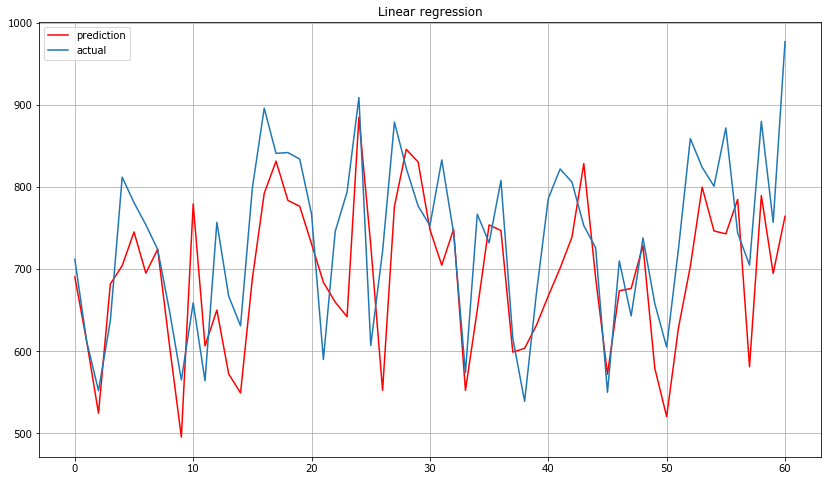

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

**Из графика видно, что предсказания стали немного другими.**

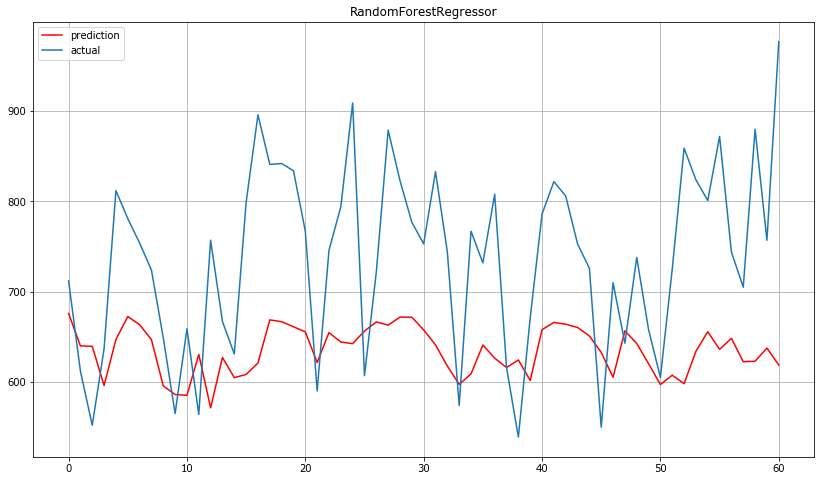

In [19]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=3, random_state=0,n_estimators=100)
rfr.fit(X_train, y_train)
prediction = rfr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("RandomForestRegressor")
plt.grid(True);

**Как мы видим, один из методов классического ML показал хуже результаты.**